# AdSel Modeling
## Step 3: Modeling
### Step 3b: Check/validate model performance

The purpose of this script is to test the performance of the AA predictive models. This is an optional script in the pipeline.

### Goals

* Determine performance of AA predictive models

### Process

* A. Load data and modules
* B. Set configurations
* C. Preprocessing
* D. Splits and scaling
* E. Predictions
* F. Check predictions
* G. Check prediction performance
* H. Save errors
* I. Historic predictions

## Part A - Load data and modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('../../data/processed_data/dataForAaPredictions.csv')

In [4]:
data.head()

,folderId,applicationType,aaScore,gpa,ibDiplomaProjected,hsMathLevel,deficiencyArts,yrsArts,deficiencyEnglish,yrsEnglish,...,hasCollegeGpa,hasCollegeCredits,avoidedIb,avoidedAp,highTOEFL,highIELTS,predictedSAT,calcPredictedSAT,predictedTOEFL,calcPredictedTOEFL
0,3890DAA4-A2AC-E911-90FA-00505692D664,Freshman,6.0,3.18,False,4.0,0.0,2.385866,0.0,4.016217,...,False,False,False,False,False,False,1092.058343,False,91.961422,False
1,E83E41B7-7FB3-E911-90FA-00505692D664,Freshman,9.0,3.16,False,4.0,0.0,2.386164,0.0,4.016098,...,True,False,False,False,False,False,1166.142872,False,106.588089,False
2,EB6B2BB9-FFB8-E911-90FA-00505692D664,Freshman,17.0,3.95,False,5.0,0.0,2.225078,0.0,4.005917,...,False,False,False,False,False,False,1288.544566,False,98.241332,False
3,BEFDE9D7-C7C4-E911-90FB-00505692D664,Freshman,12.0,3.90,False,5.0,0.0,2.309290,0.0,4.001536,...,False,False,False,False,False,False,1266.920987,False,104.599934,False
4,35D869E3-EDC7-E911-90FB-00505692D664,Freshman,8.0,3.46,False,3.0,0.0,2.386164,0.0,4.016098,...,True,False,False,False,False,False,856.910316,False,97.773096,False


In [5]:
data.columns

Index(['folderId', 'applicationType', 'aaScore', 'gpa', 'ibDiplomaProjected',
       'hsMathLevel', 'deficiencyArts', 'yrsArts', 'deficiencyEnglish',
       'yrsEnglish',
       ...
       'hasCollegeGpa', 'hasCollegeCredits', 'avoidedIb', 'avoidedAp',
       'highTOEFL', 'highIELTS', 'predictedSAT', 'calcPredictedSAT',
       'predictedTOEFL', 'calcPredictedTOEFL'],
      dtype='object', length=314)

## Part B - Set configurations

In [6]:
saveErrors = True

In [7]:
allData = data.copy()
allData = allData[allData.entryYear < 2020]

In [8]:
studentTag = 'non-resident' #what types of students to look at? resident, non-resident, international

allData = allData[allData[studentTag] == 1]
paramLocDict = {
    'resident': '../../outputs/resAaParams.pkl',
    'non-resident' : '../../outputs/dnrAaParams.pkl',
    'international' : '../../outputs/intlAaParams.pkl'
}
paramLoc = paramLocDict[studentTag]

In [9]:
if os.path.isfile(paramLoc):
    with open(paramLoc, 'rb') as pickleIn:
        params = pickle.load(pickleIn)
else:
    params = {}

In [10]:
params

{'learning_rate': 0.1,
 'max_depth': 9,
 'max_features': 0.5,
 'min_samples_leaf': 5,
 'min_samples_split': 10}

In [11]:
len(allData)

87963

## Part C - Preprocessing

Text(0, 0.5, 'Count')

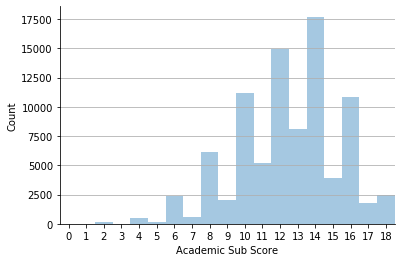

In [12]:
ax = plt.subplot(111)
p = sns.distplot(allData.aaScore, bins = np.arange(0, allData.aaScore.max() + 2), norm_hist = False, 
                 kde = False)
p.set(xticks= np.arange(0.5, allData.aaScore.max() + 1.5), 
      xticklabels = [str(int(x)) for x in np.arange(0, allData.aaScore.max() + 1)],
      zorder = 10);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.grid(axis = 'y', zorder = 1)

plt.xlim([0, 19])

plt.xlabel('Academic Sub Score')
plt.ylabel('Count')

In [13]:
cols = []
for col in allData.columns:
    current = allData[col]
    for each in current:
        try:
            float(each)
        except ValueError:
            cols.append(col)

In [14]:
cols = list(set(cols))

In [15]:
cols

['folderId', 'applicationType']

In [16]:
allData = allData.drop(cols, axis = 1).astype(float)

In [17]:
allData = allData[allData.aaScore.notna()]

## Part D - Splits and scaling

### Train/test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(allData.drop(['aaScore'], axis = 1), 
                                                    allData.aaScore, test_size = 0.2, random_state = 11)

In [19]:
y_test = pd.DataFrame(y_test)
y_test['hold'] = 1
y_train = pd.DataFrame(y_train)
y_train['hold'] = 1

In [20]:
xcols = X_train.columns
ycols = y_train.columns

### Scaling

In [21]:
scaler = MinMaxScaler().fit(X_train)

In [22]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
scalerY = MinMaxScaler().fit(y_train)

In [24]:
y_train = scalerY.transform(y_train)
y_test = scalerY.transform(y_test)

In [25]:
X_train = pd.DataFrame(X_train, columns = xcols)
X_test = pd.DataFrame(X_test, columns = xcols)
y_train = pd.DataFrame(y_train, columns = ycols)
y_test = pd.DataFrame(y_test, columns = ycols)

In [26]:
y_train = y_train.drop(['hold'], axis = 1)
y_test = y_test.drop(['hold'], axis = 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D95462ACC8>]],
      dtype=object)

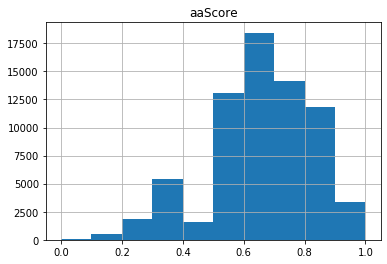

In [27]:
y_train.hist()

## Part E - Predictions

### "Actual" predictions

In [28]:
xgb = GradientBoostingRegressor(**params)
xgb.fit(X_train, y_train)

c:\users\laulck\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=9,
                          max_features=0.5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Lower bound

In [29]:
xgbLow = GradientBoostingRegressor(**params, loss='quantile', alpha = 0.05)
xgbLow.fit(X_train, y_train)

c:\users\laulck\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.05, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='quantile', max_depth=9,
                          max_features=0.5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Upper bound

In [30]:
xgbHigh = GradientBoostingRegressor(**params, loss='quantile', alpha = 0.95)
xgbHigh.fit(X_train, y_train)

c:\users\laulck\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.95, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='quantile', max_depth=9,
                          max_features=0.5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Part F - Check predictions

### Density plots

In [31]:
preds = pd.DataFrame(xgb.predict(X_train))
preds['hold'] = 0
y_rescaled = y_train.copy()
y_rescaled['hold'] = 0

In [32]:
preds_rescaled = scalerY.inverse_transform(preds)
y_rescaled = scalerY.inverse_transform(y_rescaled)

In [33]:
predsAll = pd.DataFrame(xgb.predict(X_train.append(X_test)))
predsAll['hold'] = 0
preds_all_rescaled = scalerY.inverse_transform(predsAll)[:,0]

Text(0, 0.5, 'Density')

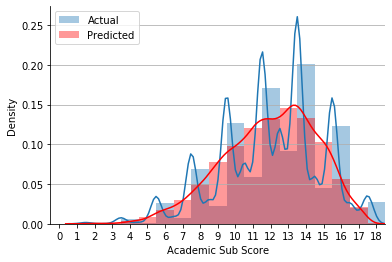

In [34]:
ax = plt.subplot(111)
p = sns.distplot(allData.aaScore, bins = np.arange(0, allData.aaScore.max() + 2))
p.set(xticks= np.arange(0.5, allData.aaScore.max() + 1.5), 
      xticklabels = [str(int(x)) for x in np.arange(0, allData.aaScore.max() + 1)],
      zorder = 10);

p2 = sns.distplot(preds_all_rescaled, bins = np.arange(0, allData.aaScore.max() + 2), color = 'red')
p2.set(xticks= np.arange(0.5, allData.aaScore.max() + 1.5), 
      xticklabels = [str(int(x)) for x in np.arange(0, allData.aaScore.max() + 1)],
      zorder = 10);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.grid(axis = 'y', zorder = 1)

plt.xlim([0, 19])

plt.legend(['Actual', 'Predicted'])

plt.xlabel('Academic Sub Score')
plt.ylabel('Density')

### Errors

In [35]:
errors = (preds_rescaled[:,0] - y_rescaled[:,0])

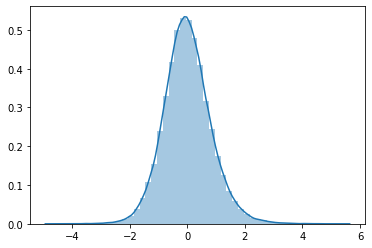

In [36]:
sns.distplot(errors)

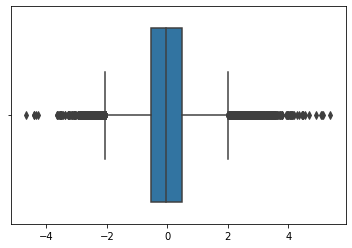

In [37]:
sns.boxplot(errors)

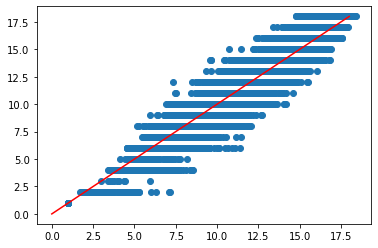

In [38]:
plt.scatter(preds_rescaled, y_rescaled)
plt.plot(np.arange(0, 19), np.arange(0, 19), 'r-')

### Create error DF

In [39]:
preds_test_xgb = pd.DataFrame(xgb.predict(X_test))
preds_test_xgb['hold'] = 0

In [40]:
preds_test_xgb_low = pd.DataFrame(xgbLow.predict(X_test))
preds_test_xgb_low['hold'] = 0

In [41]:
preds_test_xgb_high = pd.DataFrame(xgbHigh.predict(X_test))
preds_test_xgb_high['hold'] = 0

In [42]:
y_test_rescaled = y_test.copy()
y_test_rescaled['hold'] = 0

In [43]:
preds_test_xgb = scalerY.inverse_transform(preds_test_xgb)[:,0]
preds_test_xgb_low = scalerY.inverse_transform(preds_test_xgb_low)[:,0]
preds_test_xgb_high = scalerY.inverse_transform(preds_test_xgb_high)[:,0]
y_test_rescaled = scalerY.inverse_transform(y_test_rescaled)[:,0]

In [44]:
outs = pd.DataFrame({'low': preds_test_xgb_low, 'mid': preds_test_xgb, 'high': preds_test_xgb_high, 'actual': y_test_rescaled})

In [45]:
outs['check'] = (outs['actual'] >= outs['low']) & (outs['actual'] <= outs['high'])

In [46]:
outs

,low,mid,high,actual,check
0,7.599864,9.713259,11.900009,10.0,True
1,10.092251,12.468051,14.048719,13.0,True
2,13.417428,14.881675,16.442244,16.0,True
3,11.436844,13.127181,14.857626,14.0,True
4,8.443987,10.353549,12.135551,9.0,True
...,...,...,...,...,...
17588,11.700117,13.479984,15.041388,14.0,True
17589,11.857465,13.223630,14.304000,13.0,True
17590,12.158052,13.507832,15.453585,12.0,False
17591,12.115001,13.338914,14.930361,12.0,False


In [47]:
outs.check.sum() / len(outs) #How many times are we between the bounds established?

0.8472119593019951

### Round predictions

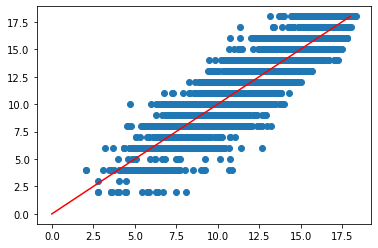

In [48]:
plt.scatter(preds_test_xgb, y_test_rescaled)
plt.plot(np.arange(0, 19), np.arange(0, 19), 'r-')

In [49]:
np.sqrt(mean_squared_error(preds_test_xgb, y_test_rescaled))

1.0813414895769504

In [50]:
rounded = np.round(preds_test_xgb)

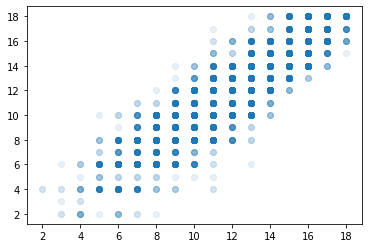

In [51]:
plt.scatter(rounded, y_test_rescaled, alpha = 0.1)

In [52]:
yhatSeries = pd.Series(rounded)

In [53]:
ySeries = pd.Series(y_test_rescaled)

(array([   8.,   23.,   69.,  210.,  390.,  673., 1136., 3536., 2299.,
        2464., 2533., 2085., 1404.,  763.]),
 array([ 2.        ,  3.14285714,  4.28571429,  5.42857143,  6.57142857,
         7.71428571,  8.85714286, 10.        , 11.14285714, 12.28571429,
        13.42857143, 14.57142857, 15.71428571, 16.85714286, 18.        ]),
 <a list of 14 Patch objects>)

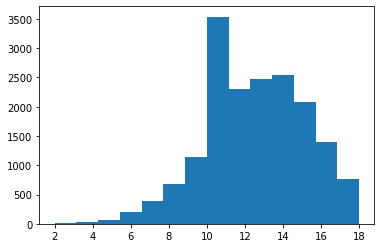

In [54]:
plt.hist(rounded, bins = 14)

(array([2.000e+01, 3.000e+00, 1.090e+02, 1.800e+01, 4.600e+02, 1.060e+02,
        1.220e+03, 4.220e+02, 2.262e+03, 1.030e+03, 3.022e+03, 1.591e+03,
        3.546e+03, 8.100e+02, 2.149e+03, 8.250e+02]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18.]),
 <a list of 16 Patch objects>)

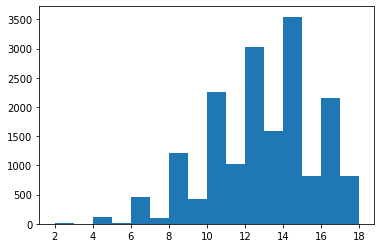

In [55]:
plt.hist(y_test_rescaled, bins = 16)

In [56]:
diffs = ySeries - rounded

(array([5.000e+00, 1.200e+01, 5.600e+01, 1.280e+03, 3.903e+03, 6.843e+03,
        5.306e+03, 1.470e+02, 3.500e+01, 6.000e+00]),
 array([-7. , -5.7, -4.4, -3.1, -1.8, -0.5,  0.8,  2.1,  3.4,  4.7,  6. ]),
 <a list of 10 Patch objects>)

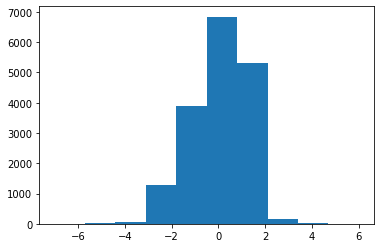

In [57]:
plt.hist(diffs)

## Part G - Check prediction performance

In [58]:
counts = np.round(np.abs(diffs)).value_counts()
counts

1.0    8192
0.0    6843
2.0    2056
3.0     388
4.0      91
5.0      17
7.0       3
6.0       3
dtype: int64

In [59]:
# Bar errors: what pct of time are we correct? Off by <=1 point? Off by <=2 points?
total = counts.sum()

bars = [counts[0] / total * 100, (counts[0] + counts[1]) / total * 100, 
 (counts[0] + counts[1] + counts[2]) / total * 100]
bars

[38.89615187858808, 85.46012618655146, 97.14659239470244]

In [60]:
# Similar to above only not using rounded values
total = len(errors)

abs_errors = np.abs(errors)
cumSteps = []
cum = []
step = 0.001
for current in np.arange(0, 2.5 + step, step):
    value = len(abs_errors[abs_errors < current])
    cum.append(value)
    if current in [0.1, 0.5, 1, 2]:
        print (current, value, value / total * 100)
        cumSteps.append((current, value / total * 100))
    
cum = np.array(cum) / total * 100

0.1 7485 10.636634929657525
0.5 34667 49.26389086258349
1.0 56316 80.02842120221685
2.0 68846 97.83430439107575


Text(0, 0.5, 'Pct of Held Out (cumulative)')

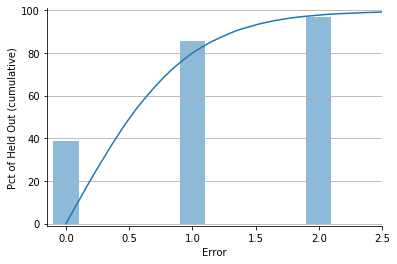

In [61]:
#plot of bars from above
ax = plt.subplot(111)
plt.plot(np.arange(0, 2.5 + step, step), cum)
plt.bar([0, 1, 2], bars, width = 0.2, alpha = 0.5)
plt.plot([])
plt.xlim([-0.15, 2.5])
plt.ylim(-1, 101)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.grid(axis = 'y')

plt.xlabel('Error')
plt.ylabel('Pct of Held Out (cumulative)')

In [62]:
print ("RMSE: ", np.sqrt(mean_squared_error(preds_test_xgb, y_test_rescaled)))
print ("Median: ", np.median(np.abs(preds_test_xgb - y_test_rescaled)))
print ("Bar errors:", bars)
print ("Cum errors:", cumSteps)

RMSE:  1.0813414895769504
Median:  0.6671454948767188
Bar errors: [38.89615187858808, 85.46012618655146, 97.14659239470244]
Cum errors: [(0.1, 10.636634929657525), (0.5, 49.26389086258349), (1.0, 80.02842120221685), (2.0, 97.83430439107575)]


## Part H - Save errors

In [63]:
if saveErrors:
    errorFile = '../../outputs/errorsAa' + studentTag.title().replace('-','') + '.csv'
    outs.to_csv(errorFile, index = False)

## Part I - Historic predictions

In [64]:
#RES

#RMSE:  0.9981273978337988
#Median:  0.6192058332745018
#Bar errors: [41.260245901639344, 87.73565573770492, 98.20696721311475]
#Cum errors: [(0.1, 9.88318475253612), (0.5, 46.677425965775186), (1.0, 77.66676913618198), (2.0, 97.589404652116)]

In [65]:
#DNR

#RMSE:  1.0813340900226154
#Median:  0.6629645098934969
#Bar errors: [38.99278121980333, 85.19865855738078, 97.16364463138748]
#Cum errors: [(0.1, 10.444791814693762), (0.5, 49.10046894983658), (1.0, 79.87636777035668), (2.0, 97.85419923262754)]

In [66]:
#INTL

#RMSE:  2.329473159820949
#Median:  0.9684474713059008
#Bar errors: [33.27356557377049, 63.70389344262295, 79.41854508196722]
#Cum errors: [(0.1, 11.142418032786885), (0.5, 41.26857069672131), (1.0, 62.247054303278695), (2.0, 82.95658299180327)]